<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221113.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime, date, time, timezone, timedelta 
import os
import re

from functools import reduce
from collections import defaultdict

import prophet as pr

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'KPMG_VI_New_raw_data_update_final.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 '1_order_payments_dataset.csv',
 'sales.csv',
 'sample-sales-data.csv',
 '1_customers_dataset.csv',
 'mall_customers.csv',
 'online_retail_II.xlsx',
 'scanner_data.csv',
 'sales_data_with_stores.csv',
 'match_result_test.csv',
 'online_retail.xlsx',
 'mock_sales_data.csv',
 '1_orders_dataset.csv',
 'ecommerce-data.csv',
 'bz_data_analyis.csv',
 'test.csv',
 'groceries.csv',
 'sales_vs_discount.csv',
 'sample_data']

In [4]:
df = pd.read_csv('bz_data_analyis.csv')
df['order_date'] = pd.to_datetime(df['order_date'], infer_datetime_format=True)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.


,customer_id,product,quantity_ordered,price_each,purchase_address,month,year,day,city,code,sales,order_date,hour,minute,count
0,295665,Macbook Pro Laptop,1,1700.00,"136 Church St, New York City, NY 10001",12,2019,30,New York City (NY),NY,1700.00,2019-12-30 00:01:00,0,1,1
1,295666,LG Washing Machine,3,600.00,"562 2nd St, New York City, NY 10001",12,2019,29,New York City (NY),NY,600.00,2019-12-29 07:03:00,7,3,1
2,295667,USB-C Charging Cable,3,11.95,"277 Main St, New York City, NY 10001",12,2019,12,New York City (NY),NY,11.95,2019-12-12 18:21:00,18,21,1
3,295668,27in FHD Monitor,2,149.99,"410 6th St, San Francisco, CA 94016",12,2019,22,San Francisco (CA),CA,149.99,2019-12-22 15:13:00,15,13,1
4,295669,USB-C Charging Cable,1,11.95,"43 Hill St, Atlanta, GA 30301",12,2019,18,Atlanta (GA),GA,11.95,2019-12-18 12:38:00,12,38,1


In [12]:
df['quantity_ordered'] = df['quantity_ordered'].apply(lambda x : np.where(re.search(r'\+', str(x)), '1', x)  )
df['quantity_ordered'] = df['quantity_ordered'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   customer_id       185950 non-null  int64         
 1   product           185950 non-null  object        
 2   quantity_ordered  185950 non-null  int64         
 3   price_each        185950 non-null  float64       
 4   purchase_address  185950 non-null  object        
 5   month             185950 non-null  int64         
 6   year              185950 non-null  int64         
 7   day               185950 non-null  int64         
 8   city              185950 non-null  object        
 9   code              185950 non-null  object        
 10  sales             185950 non-null  float64       
 11  order_date        185950 non-null  datetime64[ns]
 12  hour              185950 non-null  int64         
 13  minute            185950 non-null  int64         
 14  coun

In [14]:
df['ds'] = df['order_date'].to_numpy().astype('datetime64[D]')
df['rev'] = df.quantity_ordered * df.price_each

In [19]:
list_product = df['product'].value_counts().reset_index().rename(columns = {'index':'product', 'product':'cnt'})
list_product['cat'] = ['cable', 'cable', 'battery', 'battery', 'headphone', 'headphone','headphone','monitor',
                       'mobile', 'monitor', 'monitor', 'mobile', 'tv', 'laptop', 'laptop', 'monitor',
                       'mobile', 'white', 'white']
products = dict(zip(list_product['product'], list_product['cat']))
products

{'USB-C Charging Cable': 'cable',
 'Lightning Charging Cable': 'cable',
 'AAA Batteries (4-pack)': 'battery',
 'AA Batteries (4-pack)': 'battery',
 'Wired Headphones': 'headphone',
 'Apple Airpods Headphones': 'headphone',
 'Bose SoundSport Headphones': 'headphone',
 '27in FHD Monitor': 'monitor',
 'iPhone': 'mobile',
 '27in 4K Gaming Monitor': 'monitor',
 '34in Ultrawide Monitor': 'monitor',
 'Google Phone': 'mobile',
 'Flatscreen TV': 'tv',
 'Macbook Pro Laptop': 'laptop',
 'ThinkPad Laptop': 'laptop',
 '20in Monitor': 'monitor',
 'Vareebadd Phone': 'mobile',
 'LG Washing Machine': 'white',
 'LG Dryer': 'white'}

In [20]:
df['cat'] = df['product'].apply(lambda x : products.get(x,x))
df.head()

,customer_id,product,quantity_ordered,price_each,purchase_address,month,year,day,city,code,sales,order_date,hour,minute,count,ds,rev,cat
0,295665,Macbook Pro Laptop,1,1700.00,"136 Church St, New York City, NY 10001",12,2019,30,New York City (NY),NY,1700.00,2019-12-30 00:01:00,0,1,1,2019-12-30,1700.00,laptop
1,295666,LG Washing Machine,3,600.00,"562 2nd St, New York City, NY 10001",12,2019,29,New York City (NY),NY,600.00,2019-12-29 07:03:00,7,3,1,2019-12-29,1800.00,white
2,295667,USB-C Charging Cable,3,11.95,"277 Main St, New York City, NY 10001",12,2019,12,New York City (NY),NY,11.95,2019-12-12 18:21:00,18,21,1,2019-12-12,35.85,cable
3,295668,27in FHD Monitor,2,149.99,"410 6th St, San Francisco, CA 94016",12,2019,22,San Francisco (CA),CA,149.99,2019-12-22 15:13:00,15,13,1,2019-12-22,299.98,monitor
4,295669,USB-C Charging Cable,1,11.95,"43 Hill St, Atlanta, GA 30301",12,2019,18,Atlanta (GA),GA,11.95,2019-12-18 12:38:00,12,38,1,2019-12-18,11.95,cable


In [21]:
cnt = df.groupby(['ds', 'cat'])['rev'].sum().reset_index().rename(columns = {'rev':'y'})
cnt.head()

,ds,cat,y
0,2019-01-01,battery,309.11
1,2019-01-01,cable,1141.75
2,2019-01-01,headphone,5021.54
3,2019-01-01,laptop,24299.91
4,2019-01-01,mobile,19200.00


In [41]:
def get_plot(df) :
  list_work = list_product['cat']

  res = list()

  for worker in list_work :

    temp = cnt[cnt['cat'] == worker].reindex(['ds','y'], axis = 1)
    
    m = pr.Prophet().fit(cnt)
    future = m.make_future_dataframe(periods = 60)
    forecast = m.predict(future)

    temp = forecast[['ds', 'trend', 'yhat']]
    temp.insert(0, 'cat', worker)

    res.append(temp)

  return res

In [42]:
res = get_plot(cnt)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3nzjmpe6/la4s0o01.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3nzjmpe6/qerkrm3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20329', 'data', 'file=/tmp/tmp3nzjmpe6/la4s0o01.json', 'init=/tmp/tmp3nzjmpe6/qerkrm3c.json', 'output', 'file=/tmp/tmp3nzjmpe6/prophet_modelu6fke7fm/prophet_model-20221113004255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:42:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:42:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

In [43]:
res = pd.concat(res).reset_index().drop(['index'], axis = 1)
res.head()

,cat,ds,trend,yhat
0,cable,2019-01-01,7954.834612,8137.061300
1,cable,2019-01-02,7997.491390,7982.599889
2,cable,2019-01-03,8040.148168,7989.664293
3,cable,2019-01-04,8082.804946,7967.935461
4,cable,2019-01-05,8125.461724,8152.172126


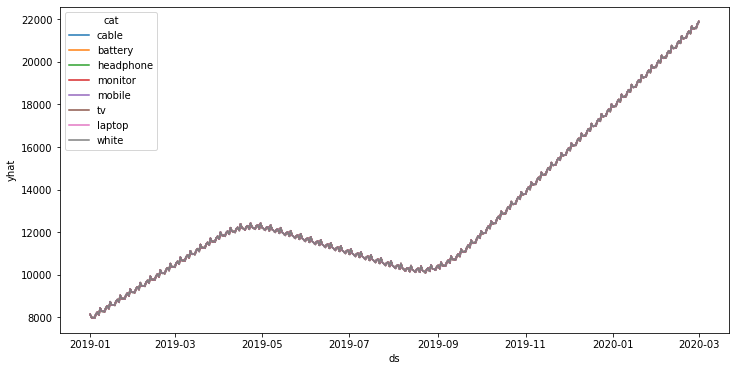

In [45]:
plt.figure(figsize = (12,6))
sns.lineplot(data = res, x = 'ds', y = 'yhat', hue = 'cat')

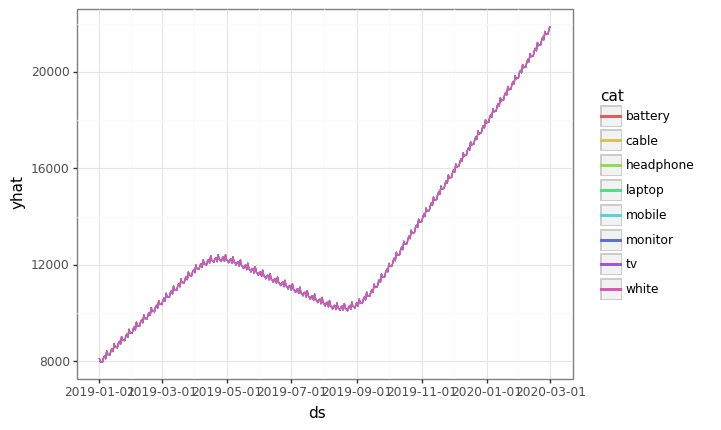

<ggplot: (8772936040161)>

In [46]:
(
    ggplot(res, aes('ds', 'yhat', color = 'cat')) +
    gg.geom_line() +
    gg.theme_bw()
)

# Iterator

In [47]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [50]:
a = {k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}
a

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [51]:
reduce(lambda x, y : x + y['age'], users, 0)

227

In [52]:
pd.DataFrame(a)

,mail,name,sex,age
0,gregorythomas@gmail.com,Brett Holland,M,73
1,hintoncynthia@hotmail.com,Madison Martinez,F,29
2,wwagner@gmail.com,Michael Jenkins,M,51
3,daniel79@gmail.com,Karen Rodriguez,F,32
4,ujackson@gmail.com,Amber Rhodes,F,42


In [62]:
names = np.random.choice(['park', 'kim', 'lee'], 100, replace = True)

def get_score(names) : 
    uniques, counts = np.unique(names, return_counts=True)
    unique = dict(zip(uniques, counts))

    res = list()

    for k, v in unique.items() :

      m = np.random.normal(50, 30, 1)
      s = np.random.randint(3, 10, 1)

      score = [abs(a) if a <= 100 else 100 for a in np.random.normal(abs(m), s, v)]
      temp = pd.DataFrame({'name' : np.repeat(k, v), 'score' : score})
      res.append(temp)

    res = pd.concat(res).reset_index().drop(['index'], axis = 1)

    return res

res = get_score(names)
res.head()

,name,score
0,kim,50.869059
1,kim,65.018963
2,kim,49.547685
3,kim,57.861625
4,kim,38.564198


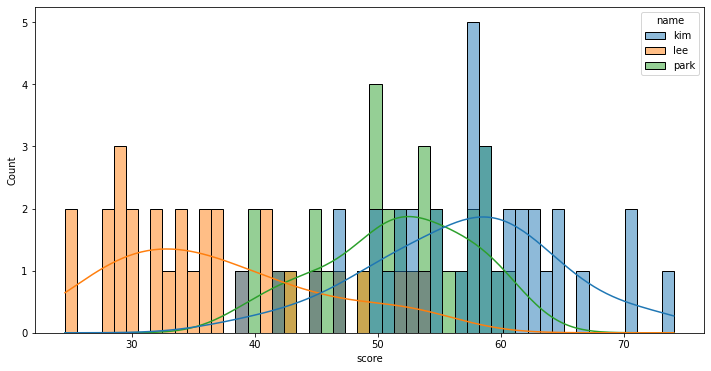

In [63]:
plt.figure(figsize = (12,6))
sns.histplot(data = res, x = 'score', hue = 'name', kde = True, bins = 50)